In [117]:
from selenium import webdriver
from selenium.webdriver.common.action_chains import ActionChains
from bs4 import BeautifulSoup

import requests
import matplotlib.pyplot as plt
import numpy
import pandas as pd  
from math import *
import time, datetime
import sys
sys.version

'3.7.3 (default, Mar 27 2019, 17:13:21) [MSC v.1915 64 bit (AMD64)]'

In [118]:
now = str(time.time()).split('.')[0]
print(now)
print(str(datetime.datetime.now()).split('.')[0])

1580345563
2020-01-29 19:52:43


In [119]:
bidsAreHigh = False
maPortfolio = 25000
maCash = 25000

url = "https://query1.finance.yahoo.com/v8/finance/chart/%5EGSPC?symbol=%5EGSPC&period1={}&period2={}&interval={}&includePrePost=true&events=div%7Csplit%7Cearn&lang=en-US&region=US&crumb=ED2zlWJHcMa&corsDomain=finance.yahoo.com"
monthAgo = time.time() - 2419200
weekAgo = time.time() - 386329

r = requests.get(url.format(str(weekAgo).split('.')[0], now, '5m'))

# r = requests.get(url.format(str(monthAgo).split('.')[0], now, '30m'))
# r = requests.get("""https://query1.finance.yahoo.com/v8/finance/chart/%5EGSPC?symbol=%5EGSPC&period1=1574186393&period2=1576778393&interval=30m&includePrePost=true&events=div%7Csplit%7Cearn&lang=en-US&region=US&crumb=ED2zlWJHcMa&corsDomain=finance.yahoo.com
# """)
yahoo = r.json()
print(yahoo)
time = yahoo["chart"]["result"][0]["timestamp"]
quote = yahoo["chart"]["result"][0]["indicators"]["quote"][0]



{'chart': {'result': [{'meta': {'currency': 'USD', 'symbol': '^GSPC', 'exchangeName': 'SNP', 'instrumentType': 'INDEX', 'firstTradeDate': -1325602800, 'regularMarketTime': 1580335366, 'gmtoffset': -18000, 'timezone': 'EST', 'exchangeTimezoneName': 'America/New_York', 'regularMarketPrice': 3273.4, 'chartPreviousClose': 3295.47, 'previousClose': 3276.24, 'scale': 3, 'priceHint': 2, 'currentTradingPeriod': {'pre': {'timezone': 'EST', 'start': 1580288400, 'end': 1580308200, 'gmtoffset': -18000}, 'regular': {'timezone': 'EST', 'start': 1580308200, 'end': 1580331600, 'gmtoffset': -18000}, 'post': {'timezone': 'EST', 'start': 1580331600, 'end': 1580346000, 'gmtoffset': -18000}}, 'tradingPeriods': {'pre': [[{'timezone': 'EST', 'start': 1580115600, 'end': 1580135400, 'gmtoffset': -18000}], [{'timezone': 'EST', 'start': 1580202000, 'end': 1580221800, 'gmtoffset': -18000}], [{'timezone': 'EST', 'start': 1580288400, 'end': 1580308200, 'gmtoffset': -18000}]], 'post': [[{'timezone': 'EST', 'start': 

In [120]:
def ROC(df, n, price='Close'):
    """
    Rate of Change
    """
    M = df[price].diff(n - 1)
    N = df[price].shift(n - 1)
    result = pd.Series(M / N, name='ROC_' + str(n))
    return result

def MFI2(df, n):
    """
    Money Flow Index and Ratio
    """
    PP = (df['High'] + df['Low'] + df['Close']) / 3
    i = 0
    PosMF = [0]
    while i < len(df) - 1:  # df.index[-1]:
        if PP[i + 1] > PP[i]:
            PosMF.append(PP[i + 1] * df.iat[i + 1, df.columns.get_loc('Volume')])
        else:
            PosMF.append(0)
        i=i + 1
    PosMF = pd.Series(PosMF)
    TotMF = PP * df['Volume']
    MFR = pd.Series(PosMF / TotMF)
    result = pd.Series(MFR.rolling(n).mean(), name='MFI_' + str(n))
    return result

def RSI(df, n):
    """
    Relative Strength Index
    """
    i = 0
    UpI = [0]
    DoI = [0]
    while i + 1 <= len(df) - 1:  # df.index[-1]
        UpMove = df.iat[i + 1, df.columns.get_loc('High')] - df.iat[i, df.columns.get_loc('High')]
        DoMove = df.iat[i, df.columns.get_loc('Low')] - df.iat[i + 1, df.columns.get_loc('Low')]
        if UpMove > DoMove and UpMove > 0:
            UpD = UpMove
        else:
            UpD = 0
        UpI.append(UpD)
        if DoMove > UpMove and DoMove > 0:
            DoD = DoMove
        else:
            DoD = 0
        DoI.append(DoD)
        i = i + 1
    UpI = pd.Series(UpI)
    DoI = pd.Series(DoI)
    PosDI = pd.Series(UpI.ewm(span=n, min_periods=n - 1).mean())
    NegDI = pd.Series(DoI.ewm(span=n, min_periods=n - 1).mean())
    result = pd.Series(PosDI / (PosDI + NegDI), name='RSI_' + str(n))
    return result

def STDDEV(df, n):
    """
    Standard Deviation
    """
    result = pd.Series(df['Close'].rolling(n).std(), name='STD_' + str(n))
    return result

# intialise data of lists. 
data = {'Open': quote['open'] , 
        'Low': quote['low'] , 
        'High': quote['high'], 
        'Close': quote['close'],
        'Volume': quote['volume']} 
  
# Create DataFrame 
df = pd.DataFrame(data) 
  
# Print the output. 
df 

,Open,Low,High,Close,Volume
0,3236.760010,3236.300049,3245.389893,3244.219971,0.0
1,3243.229980,3241.219971,3247.229980,3246.820068,48380070.0
2,3246.909912,3245.090088,3248.159912,3247.929932,29561102.0
3,3249.620117,3249.179932,3252.409912,3250.610107,47729738.0
4,3250.489990,3249.570068,3253.919922,3253.219971,35106129.0
5,3253.169922,3248.729980,3253.389893,3252.189941,31240926.0
6,3252.389893,3246.709961,3252.500000,3246.709961,29875784.0
7,3246.909912,3244.590088,3249.580078,3249.580078,29787898.0
8,3249.729980,3246.239990,3249.729980,3247.830078,25828419.0
9,3247.850098,3244.159912,3249.570068,3244.489990,24926022.0


<class 'numpy.float64'>


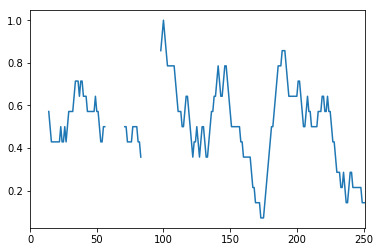

In [121]:
# mf = MFI(df, 14)
mfi = MFI2(df, 14)
mfi.plot()
# mf
print(type(mfi[0]))
# mfi.values[-1:][0]
# print(df['Volume'].mean())
# print(df['Volume'].mean() / 100 * 150)
# highs = df[df['Volume'] > df['Volume'].mean() / 100 * 140]
# print('highs \n', highs)
# # if df['Close']
# df.iloc[[1,2], :]
# print(highs.values[0][3])
# highs.values[0][0]
# idx = df.index[df['Volume'] > df['Volume'].mean() / 100 * 130]
# print('len(idx)', idx[0])
# df.loc[idx]
# for i in range(len(idx)):
#     print(df['Close'][idx[i]-1])
#     if int(df['Close'][idx[i]-1]) > int(df['Close'][idx[i]]):
#         print ('bearish volume', df['Volume'][idx[i]])
#     else:
#         print ('bullish volume', df['Volume'][idx[i]])

In [62]:
# roc = ROC(df ,14)
# roc.plot()
def RVI(df, n, high='High', low='Low'):
    """
    Relative Volatility Index
    """
    rvi_list = []
    h_upavg = .0
    h_dnavg = .0
    l_upavg = .0
    l_dnavg = .0
    i = 0
    while i < len(df[low]):
        if i + 1 < n or i < 9:
            h_rvi = float('NaN')
            l_rvi = float('NaN')
        else:
            start = i + 1 - n
            end = i + 1
            h = df[high][start:end]
            h_stdev = STDEV({'h': h}, 9, 'h')[-1]
            if df[high][i] > df[high][i - 1]:
                h_up = h_stdev
                h_dn = 0
            else:
                h_up = 0
                h_dn = h_stdev
            h_upavg = (h_upavg * (n - 1) + h_up) / n
            h_dnavg = (h_dnavg * (n - 1) + h_dn) / n
            h_rvi = 100 * h_upavg / (h_upavg + h_dnavg)
            l = df[low][start:end]
            l_stdev = STDEV({'l': l}, 9, 'l')[-1]
            if df[low][i] > df[low][i - 1]:
                l_up = l_stdev
                l_dn = 0
            else:
                l_up = 0
                l_dn = l_stdev
            l_upavg = (l_upavg * (n - 1) + l_up) / n
            l_dnavg = (l_dnavg * (n - 1) + l_dn) / n
            l_rvi = 100 * l_upavg / (l_upavg + l_dnavg)
        rvi = (h_rvi + l_rvi) / 2
        rvi_list.append(rvi)
        i += 1
    return rvi_list


def STDEV(df, n, price='Close', xbar=None):
    """
    Sample standard deviation of data
    """
    stdev_list = []
    i = 0
    if n == len(df[price]):
        start = None
        while i < len(df[price]):
            if df[price][i] != df[price][i]:
                stdev = float('NaN')
            else:
                if start is None:
                    start = i
                end = i + 1
                if len(df[price][start:end]) < 2:
                    stdev = float('NaN')
                else:
                    stdev = stdev(df[price][start:end], xbar)
            stdev_list.append(stdev)
            i += 1
    else:
        while i < len(df[price]):
            if i + 1 < n:
                stdev = float('NaN')
            else:
                start = i + 1 - n
                end = i + 1
                if len(df[price][start:end]) < 2:
                    stdev = float('NaN')
                else:
                    stdev = stdev(df[price][start:end], xbar)
            stdev_list.append(stdev)
            i += 1
    return stdev_list

std = RVI(df, 14)
std.plot()




TypeError: 'float' object is not callable

In [2]:
def buy(stockPrice, n):
#     getAmount
#     subtract
#     keep the amount as a sum of stock value and the remaining cash
    stocksValue = stockPrice * n
    maCash = maCash - stocksValue
    
book = None
bookSoup = None
browser = webdriver.Chrome('C:\chromedriver')
bookRaw = None

def startBrowser():
    global book
    global bookSoup
    global browser
    global bookRaw
    browser.get('http://markets.cboe.com/us/equities/market_statistics/book_viewer/')
    time.sleep(2)
    EDGX = browser.find_element_by_xpath('//span[text()="EDGX Equities"]')
    actions = ActionChains(browser)
    actions.pause(1)
    print(EDGX)
    actions.click(EDGX)
    actions.pause(1)
    actions.perform()
    bookRaw = browser.find_element_by_xpath('//*[@id="bookViewer0"]/div[1]/table[2]/tbody')
    price = browser.find_element_by_class_name('book-viewer__trades-price').text
#     shares = 
    book = bookRaw.get_attribute('innerHTML')
    bookSoup = BeautifulSoup(book, 'lxml').html.body
    i = 0
#     for row in bookSoup:
#         i+=1
#         print('row number %s printing' % i)
#         for subrow in row:
#             print(subrow)
    print(price)
    print('book ===============>', book)
    print('bookSoup ===============>', bookSoup)
    
    
startBrowser()

<selenium.webdriver.remote.webelement.WebElement (session="8c38baa765c95c672cdaf1335c15467a", element="29c93eb0-81f6-4394-8ee3-5c77c19fdf12")>
322.42
book ===============> 
              <tr class="book-viewer-data-row">
                  <td class="book-viewer__ask__th t5" rowspan="5" style="display: table-cell;"><i class="sprite book-viewer__sprite book-viewer__sprite--ask"></i><span class="hide">Asks</span></td>
                  <td class="book-viewer__ask book-viewer__ask-shares" id="ext-gen1052" style="display: table-cell;">3,772</td>
                  <td class="book-viewer__ask book-viewer__ask-quotes" id="ext-gen1054" style="display: none;">&nbsp;</td>
                  <td class="book-viewer__ask book-viewer__ask-price book-viewer-price" id="ext-gen1053" style="display: table-cell;">322.54</td>
                  <td class="book-viewer__trades-time" id="ext-gen1084" style="display: table-cell;">18:34:37</td>
                  <td class="book-viewer__trades-price" id="ext-gen10

In [ ]:
i = 0
attachment = []
last10Trades = browser.find_elements_by_class_name("book-viewer__trades-price")
topBidsPrice = browser.find_elements_by_class_name("book-viewer__bid-price")
topBidShares = browser.find_elements_by_class_name("book-viewer__bid-shares")
topAskPrice = browser.find_elements_by_class_name("book-viewer__ask-price")
topAskShares = browser.find_elements_by_class_name("book-viewer__ask-shares")

print(last10Trades)
print(topBidsPrice)

for i in topBids:
    if i.text > 1600:
        print(i, i.text)
# for row in bookSoup:
#     i+=1
#     print('rw number %s printing' % i)
#     r = bookRaw.find_all("td", { "class": "book-viewer__trades-price"})
#     attachment.append(r)
    
#     for subrow in row:
# #        tag.has_attr('class')
#         s = subrow.string
#         print(type(s))
#         except NavigableString: 
#             pass
print(attachment)

In [ ]:
from selenium.webdriver.common.keys import Keys
def changeStock(stock):
#     global browser
    inputt = browser.find_element_by_xpath('//*[@id="symbol0"]')
    actions = ActionChains(browser)
    actions.move_to_element(inputt)
    actions.double_click(inputt)
    actions.send_keys(Keys.BACKSPACE)
#     actions.pause(1)
    actions.send_keys(stock)
#     actions.pause(1)
    actions.send_keys(Keys.ENTER)
    actions.perform()

changeStock('EDIT')
        

In [ ]:
tvixdata = pd.read_csv("C:/Users/Ldeezy/Desktop/git_/TRADER/tvix_December26_19-tradingHours.csv") 

# tvixdata[::-1]
tvixdata.reindex(index=tvixdata.index[::-1])
tvixdata.

In [ ]:
prices = tvixdata['Last Price']
prices

In [ ]:
prices.plot()

In [ ]:
import threading

def shit():
    print('yo')

StartTime=time.time()

def action() :
    print('action ! -> time : {:.1f}s'.format(time.time()-StartTime))


class setInterval :
    def __init__(self,interval,action) :
        self.interval=interval
        self.action=action
        self.stopEvent=threading.Event()
        thread=threading.Thread(target=self.__setInterval)
        thread.start()

    def __setInterval(self) :
        nextTime=time.time()+self.interval
        while not self.stopEvent.wait(nextTime-time.time()) :
            nextTime+=self.interval
            self.action()

    def cancel(self) :
        self.stopEvent.set()

# start action every 0.6s
inter=setInterval(0.6,action)
print('just after setInterval -> time : {:.1f}s'.format(time.time()-StartTime))

# will stop interval in 5s
t=threading.Timer(5,inter.cancel)
t.start()

In [33]:
time.time()
print('time.time()=>', time.time())
today = datetime.datetime.now()
print('datetime.datetime.now()=>', today)
today_morning = today.strftime('%Y%m%d') + "000000"
today_morning
midnight = datetime.datetime.combine(datetime.datetime.today(), datetime.time.min)
time.time()
midnight


time.time()=> 1577575976.6751726
datetime.datetime.now()=> 2019-12-28 18:32:56.676170


datetime.datetime(2019, 12, 28, 0, 0)

In [18]:
result = time.localtime(1545925769)
print("result:", result)
print("\nyear:", result.tm_year)
print("tm_hour:", result.tm_hour)

result: time.struct_time(tm_year=2018, tm_mon=12, tm_mday=27, tm_hour=10, tm_min=49, tm_sec=29, tm_wday=3, tm_yday=361, tm_isdst=0)

year: 2018
tm_hour: 10


In [19]:
t = (2018, 12, 28, 8, 44, 4, 4, 362, 0)
local_time = time.mktime(t)
print("Local time:", local_time)

Local time: 1546004644.0


In [40]:
datetime.datetime.today().time()
str(datetime.datetime.today().date())

'2019-12-28'

In [105]:
>>> import time
>>> import datetime
s = str(datetime.datetime.today().date())
startOfDay = str( time.mktime(datetime.datetime.strptime(s, "%Y-%m-%d").timetuple())).split('.')[0]

In [54]:
startOfDay

'1577595600'

SyntaxError: invalid syntax (<ipython-input-71-22b849128aa8>, line 3)

40.0